<a href="https://colab.research.google.com/github/Mayurd9/KDE-test/blob/main/Statistical_Change_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# **$\textbf{All the required functions}$**

In [65]:
def small_p(xi, xj, cov):
    k_dim = s1_matrix.shape[1]          #dimensions of s1 matrix
    cov_1 = cov
    det_cov = np.linalg.det(cov)
    epsilon = 1e-2
    det_cov = max(det_cov, epsilon)

    if det_cov == 0.01:
        alpha = 1e-1
        cov_1 = cov_1 + alpha * np.identity(s1_matrix.shape[1])
        det_cov = np.linalg.det(cov_1)        #new addition 4/5/2024

    a = 1 / (((2 * np.pi) ** (k_dim / 2)) * det_cov ** 0.5)
    b = -0.5 * ((xj - xi).T @ np.linalg.inv(cov_1) @ (xj - xi))

    if b > 1000:
        print('b value', b)
    b = min(b, 50)
    p = a * np.exp(b)

    return p

In [66]:
def capital_p(i, j, cov_mat):
    summation = 0
    xi = s1_matrix[i, :].reshape(-1, 1)
    xj = s1_matrix[j, :].reshape(-1, 1)

    for k in range(len_s1):
        if k != j:
            xk = s1_matrix[k, :].reshape(-1, 1)
            summation += small_p(xk,xj, cov_mat[k])

    # Avoid division by zero
    summation = np.clip(summation,1e-4,np.inf)
    P = small_p(xi,xj,cov_mat[i]) / summation

    return  P

In [67]:
def cov_xi(i,cov_mat):
    denominator = 0
    numerator = 0

    xi = s1_matrix[i, :].reshape(-1, 1)
    for j in range(len_s1):
        if i!=j:
            xj = s1_matrix[j, :].reshape(-1, 1)
            P = capital_p(i, j, cov_mat)
            denominator += P
            numerator += P * ((xj - xi) @ (xj - xi).T)

    return numerator / denominator

In [68]:
def L(cov_mat):
    L_new = 0
    for j in range(len_s1):
        xj = s1_matrix[j, :].reshape(-1, 1)
        summation = 0
        for i in range(len_s1):
            if i!=j:
                xi = s1_matrix[i, :].reshape(-1, 1)
                summation+=small_p(xi,xj,cov_mat[i])

        summation=summation/(len_s1-1)
        L_new+=np.log(summation)

    return L_new[0][0]

In [69]:
def Algorithm1(cov_mat):
    t = 0
    phi = 0.01
    L_prev = -250

    while t < 41:
        temp = []
        for i in range(len_s1):
            temp.append(cov_xi(i,cov_mat))

        cov_mat = temp.copy()

        for i in range(len_s1):
            if np.linalg.det(cov_mat[i]) <= 0:
                alpha = 1e-2
                cov_mat[i] = cov_mat[i] + alpha * np.identity(s1_matrix.shape[1])

        L_new = L(cov_mat)

        print('L_prev=',L_prev)
        print('L_new=',L_new)
        print('t=',t)
        print('-'*50)

        if abs((L_new-L_prev)/L_prev) < phi:
            break

        else:
            L_prev=L_new
            t+=1

    return cov_mat

In [70]:
def F(T):
    s = 0
    for i in range(len_s1):
        xi = s1_matrix[i, :].reshape(-1, 1)
        s += small_p(xi,T,cov_mat[i])
    f = np.log(s/len_s1)
    return f

def EstVar(estsize,beta):
    Est = []
    for t in range(1,estsize):
        #R = s2.sample(n=len(s2), replace=True, random_state=42)
        R=s2_matrix       #Specified for image dataset, in case of non-image dataset comment this and uncomment above and below lines
        #R = R.to_numpy()
        F_R = []
        for i in range(len_s2):
            T = R[i, :].reshape(-1, 1)
            F_R.append(F(T))

        var_F_R = np.var(np.array(F_R))
        Est.append((len_s2/(len_s2-1))*var_F_R)

    V =  np.percentile(Est, estsize*(1 - beta))
    var_delta = (len_sprime + ((len_sprime**2) / len_s2))*V
    return var_delta

In [71]:
from scipy.stats import norm

def critical_value(p,stepsize):
    estsize = 100
    M = int(np.ceil((p/stepsize)-1))
    C = []
    for i in range(1, M+1):
        alpha_i = i*stepsize
        beta_i = p-alpha_i
        var_delta = EstVar(estsize,beta_i)
        mean = 0
        std_dev = np.sqrt(var_delta)
        c = norm.ppf(alpha_i, loc = mean, scale = std_dev)
        C.append(c)

    C_max = max(C)
    return C_max

In [72]:
def delta():

    a = 0
    for j in range(len_sprime):
        y = sprime_matrix[j, :].reshape(-1, 1)
        summation = 0
        for i in range(len_s1):
            x = s1_matrix[i, :].reshape(-1, 1)
            summation += small_p(x,y,cov_mat[i])

        a += np.log(summation/len_s1)

    b = 0
    for j in range(len_s1):
        y = s1_matrix[j, :].reshape(-1, 1)
        summation = 0
        for i in range(len_s1):
            x = s1_matrix[i, :].reshape(-1, 1)
            summation += small_p(x,y,cov_mat[i])

        b += (np.log(summation/len_s1))*len_sprime/len_s1

    delta = a-b

    return delta[0][0]

# $\textbf{Data Pre-processing}$

In [73]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print the shape of the training and testing data
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing data shape: (10000, 28, 28)
Testing labels shape: (10000,)


# $\textbf{Case 1: When S and S' are entirely different images}$

In [74]:
image_index_s1=50100    #we can put any number here
image_index_sprime= image_index_s1 + np.random.randint(1,10)   #Check whether these two images are different or not by running next cell. If they are not same, re-run this cell.

s1_matrix=x_train[image_index_s1]
len_s1=s1_matrix.shape[0]
s2_matrix=s1_matrix.copy()
len_s2=s2_matrix.shape[0]
sprime_matrix=x_train[image_index_sprime]
len_sprime=sprime_matrix.shape[0]

**$\textbf{Displaying images}$**

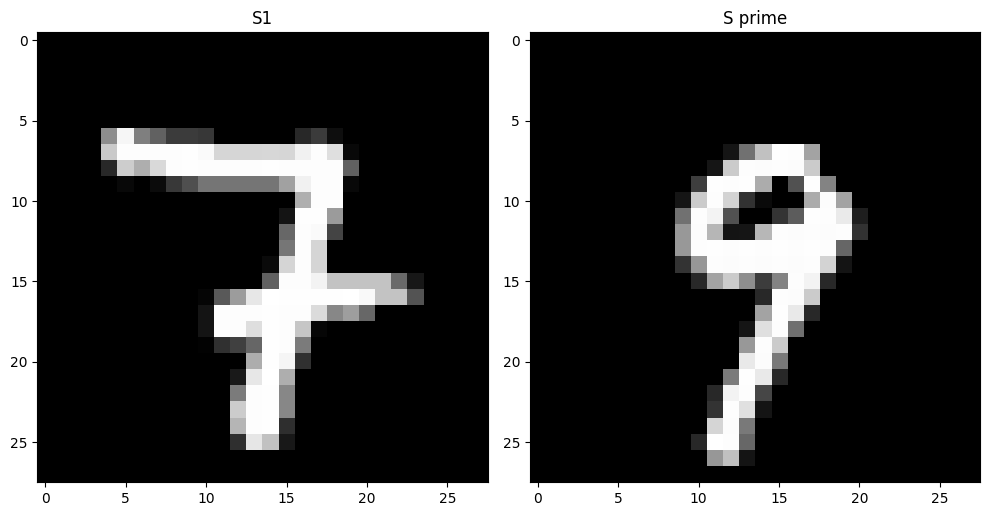

In [75]:
 #visualizing images
s1_matrix_view=s1_matrix*255
sprime_matrix_view=sprime_matrix*255

s1_matrix_view=s1_matrix*255
sprime_matrix_view=sprime_matrix*255

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(s1_matrix_view, cmap='gray')
axes[0].set_title('S1')
axes[0].axis('on')

axes[1].imshow(sprime_matrix_view, cmap='gray')
axes[1].set_title('S prime')
axes[1].axis('on')

plt.tight_layout()
plt.show()

**$\textbf{Training}$**

In [76]:
# Initial guess
cov_mat = []
for i in range(len_s1):
    xi = s1_matrix[i, :].reshape(-1, 1)
    mat = 0
    for j in range(len_s1):
        xj = s1_matrix[j, :].reshape(-1, 1)
        mat += (xj-xi) @ (xj-xi).T
    cov_mat.append(mat/(len_s1-1))

#Training
cov_mat= Algorithm1(cov_mat)

p = 0.08
stepsize = 0.02
C_max= critical_value(p,stepsize)

L_prev= -250
L_new= -24.979061419041678
t= 0
--------------------------------------------------
L_prev= -24.979061419041678
L_new= -2.7417944214373087
t= 1
--------------------------------------------------
L_prev= -2.7417944214373087
L_new= 12.923671832844727
t= 2
--------------------------------------------------
L_prev= 12.923671832844727
L_new= 26.498437651226823
t= 3
--------------------------------------------------
L_prev= 26.498437651226823
L_new= 36.745719528997235
t= 4
--------------------------------------------------
L_prev= 36.745719528997235
L_new= 42.59375909105305
t= 5
--------------------------------------------------
L_prev= 42.59375909105305
L_new= 44.80530555362608
t= 6
--------------------------------------------------
L_prev= 44.80530555362608
L_new= 45.70452806416698
t= 7
--------------------------------------------------
L_prev= 45.70452806416698
L_new= 46.07599296970359
t= 8
--------------------------------------------------


**$\textbf{Change detection decision}$**

In [77]:
Delta = delta()
print('Delta:',Delta)

if Delta < C_max:
    print('THERE IS CHANGE. DISTRIBUTION OF S PRIME IS DIFFERENT THAN DISTRIBUTION OF S ')

else:
    print('THERE IS NO CHANGE. DISTRIBUTION OF S PRIME IS SAME AS DISTRIBUTION OF S ')

Delta: -81.62426690012975
THERE IS CHANGE. DISTRIBUTION OF S PRIME IS DIFFERENT THAN DISTRIBUTION OF S 


# $\textbf{Case 2: When S and S' are same}$

In [78]:
image_index_s1 = image_index_sprime=14809    #we can put any number here
s1_matrix=x_train[image_index_s1]
len_s1=s1_matrix.shape[0]
s2_matrix=s1_matrix.copy()
len_s2=s2_matrix.shape[0]
sprime_matrix=x_train[image_index_sprime]
len_sprime=sprime_matrix.shape[0]

**$\textbf{Displaying images}$**

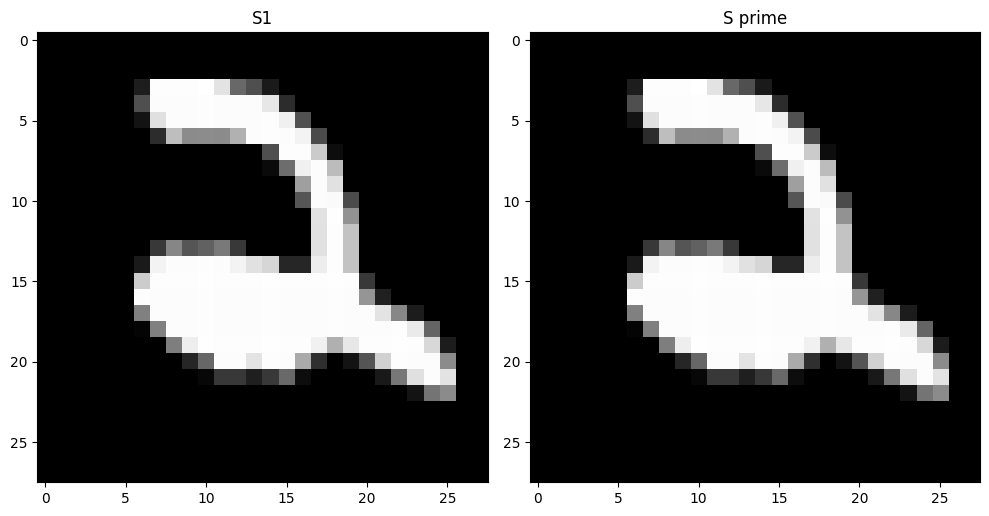

In [79]:
 #visualizing images
s1_matrix_view=s1_matrix*255
sprime_matrix_view=sprime_matrix*255

s1_matrix_view=s1_matrix*255
sprime_matrix_view=sprime_matrix*255

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(s1_matrix_view, cmap='gray')
axes[0].set_title('S1')
axes[0].axis('on')

axes[1].imshow(sprime_matrix_view, cmap='gray')
axes[1].set_title('S prime')
axes[1].axis('on')

plt.tight_layout()
plt.show()

**$\textbf{Training}$**

In [80]:
# Initial guess
cov_mat = []
for i in range(len_s1):
    xi = s1_matrix[i, :].reshape(-1, 1)
    mat = 0
    for j in range(len_s1):
        xj = s1_matrix[j, :].reshape(-1, 1)
        mat += (xj-xi) @ (xj-xi).T
    cov_mat.append(mat/(len_s1-1))

#Training
cov_mat= Algorithm1(cov_mat)

p = 0.08/2
stepsize = 0.02
C_max= critical_value(p,stepsize)

L_prev= -250
L_new= -54.223803259768275
t= 0
--------------------------------------------------
L_prev= -54.223803259768275
L_new= -32.77853295616252
t= 1
--------------------------------------------------
L_prev= -32.77853295616252
L_new= -4.205711607345112
t= 2
--------------------------------------------------
L_prev= -4.205711607345112
L_new= 15.978974878133844
t= 3
--------------------------------------------------
L_prev= 15.978974878133844
L_new= 26.60367430738666
t= 4
--------------------------------------------------
L_prev= 26.60367430738666
L_new= 30.363463968687068
t= 5
--------------------------------------------------
L_prev= 30.363463968687068
L_new= 32.652175046006434
t= 6
--------------------------------------------------
L_prev= 32.652175046006434
L_new= 35.020940653487685
t= 7
--------------------------------------------------
L_prev= 35.020940653487685
L_new= 37.04688342424929
t= 8
--------------------------------------------------
L_prev= 37.04688342424929
L_new= 3

**$\textbf{Change detection decision}$**

In [81]:
Delta = delta()
print('Delta:',Delta)

if Delta < C_max:
    print('THERE IS CHANGE. DISTRIBUTION OF S PRIME IS DIFFERENT THAN DISTRIBUTION OF S ')

else:
    print('THERE IS NO CHANGE. DISTRIBUTION OF S PRIME IS SAME AS DISTRIBUTION OF S ')

Delta: 0.0
THERE IS NO CHANGE. DISTRIBUTION OF S PRIME IS SAME AS DISTRIBUTION OF S 


# $\textbf{Case 3: Adding noise in the same image. (S' = noisy version of S)}$

**$\textbf{Adding noise in the image}$**

In [82]:
#adding noise

image_index=53629    #We can put any number here

s1_matrix=x_train[image_index]
len_s1=s1_matrix.shape[0]
s2_matrix=s1_matrix.copy()
len_s2=s2_matrix.shape[0]

sprime_matrix=x_train[image_index].copy()
len_sprime=sprime_matrix.shape[0]

"""Adding 3% noise, if it doesn't detect change, try slightly increasing noise percentage"""

for i in range(int(0.03*28*28)):
    sprime_matrix[np.random.randint(0,28), np.random.randint(0,28)]=np.random.uniform(0,1)


**$\textbf{Displaying images}$**

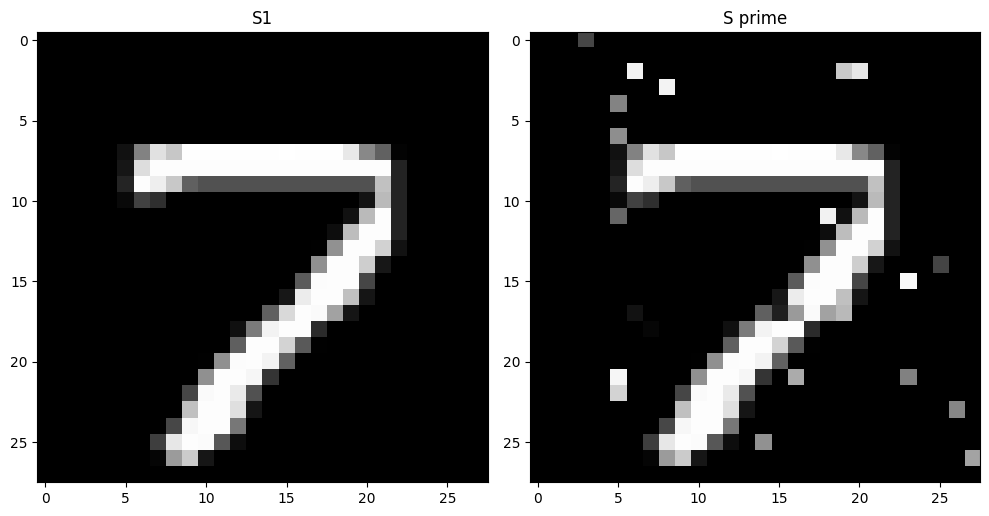

In [83]:
#Visualizing images

import matplotlib.pyplot as plt

s1_matrix_view=s1_matrix*255
sprime_matrix_view=sprime_matrix*255

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(s1_matrix_view, cmap='gray')
axes[0].set_title('S1')
axes[0].axis('on')

axes[1].imshow(sprime_matrix_view, cmap='gray')
axes[1].set_title('S prime')
axes[1].axis('on')

plt.tight_layout()
plt.show()

**$\textbf{Training for selected S1}$**

In [84]:
#Initial guess
cov_mat_initial = []

for i in range(len_s1):
    xi = s1_matrix[i, :].reshape(-1, 1)
    mat = 0
    for j in range(len_s1):
        xj = s1_matrix[j, :].reshape(-1, 1)
        mat += (xj-xi) @ (xj-xi).T

    cov_mat_initial.append(mat/(len_s1-1))

#Training
cov_mat= Algorithm1(cov_mat_initial)

p = 0.08
stepsize = 0.02
C_max= critical_value(p,stepsize)

L_prev= -250
L_new= -43.842275419465764
t= 0
--------------------------------------------------
L_prev= -43.842275419465764
L_new= -20.14056892812331
t= 1
--------------------------------------------------
L_prev= -20.14056892812331
L_new= 7.962562871482346
t= 2
--------------------------------------------------
L_prev= 7.962562871482346
L_new= 26.080088303206274
t= 3
--------------------------------------------------
L_prev= 26.080088303206274
L_new= 31.95055718815513
t= 4
--------------------------------------------------
L_prev= 31.95055718815513
L_new= 33.85029680034366
t= 5
--------------------------------------------------
L_prev= 33.85029680034366
L_new= 34.76599292403555
t= 6
--------------------------------------------------
L_prev= 34.76599292403555
L_new= 35.2330975465774
t= 7
--------------------------------------------------
L_prev= 35.2330975465774
L_new= 35.529214655706554
t= 8
--------------------------------------------------


**$\textbf{Change detection decision}$**

In [85]:
#Change detection test
Delta = delta()
print('delta:',Delta)

if Delta < C_max:
    print('THERE IS CHANGE. DISTRIBUTION OF S PRIME IS DIFFERENT THAN DISTRIBUTION OF S ')

else:
    print('THERE IS NO CHANGE. DISTRIBUTION OF S PRIME IS SAME AS DISTRIBUTION OF S ')

delta: -38.79296070504994
THERE IS CHANGE. DISTRIBUTION OF S PRIME IS DIFFERENT THAN DISTRIBUTION OF S 
